<a href="https://colab.research.google.com/github/arunravi8595/CE888/blob/main/Lab_3/facebook_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import itertools

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import accuracy_score as acc
from sklearn.metrics import make_scorer, confusion_matrix
from sklearn.dummy import DummyRegressor, DummyClassifier
from sklearn.preprocessing import LabelEncoder

In [2]:
df = pd.read_csv("https://raw.githubusercontent.com/albanda/CE888/master/lab3/dataset_Facebook.csv", delimiter = ";")

features = ["Category",
            "Page total likes",
            "Type",
            "Post Month",
            "Post Hour",
            "Post Weekday",
            "Paid"]


df[features].head()

,Category,Page total likes,Type,Post Month,Post Hour,Post Weekday,Paid
0,2,139441,Photo,12,3,4,0.0
1,2,139441,Status,12,10,3,0.0
2,3,139441,Photo,12,3,3,0.0
3,2,139441,Photo,12,10,2,1.0
4,2,139441,Photo,12,3,2,0.0


In [3]:
outcomes=  ["Lifetime Post Total Reach",
            "Lifetime Post Total Impressions",
            "Lifetime Engaged Users",
            "Lifetime Post Consumers",
            "Lifetime Post Consumptions",
            "Lifetime Post Impressions by people who have liked your Page",
            "Lifetime Post reach by people who like your Page",
            "Lifetime People who have liked your Page and engaged with your post",
            "comment",
            "like",
            "share",
            "Total Interactions"]

df[outcomes].head()

print(df[outcomes[-3:]].head().to_latex())

\begin{tabular}{lrrr}
\toprule
{} &    like &  share &  Total Interactions \\
\midrule
0 &    79.0 &   17.0 &                 100 \\
1 &   130.0 &   29.0 &                 164 \\
2 &    66.0 &   14.0 &                  80 \\
3 &  1572.0 &  147.0 &                1777 \\
4 &   325.0 &   49.0 &                 393 \\
\bottomrule
\end{tabular}



In [4]:
df[["Type"]] = df[["Type"]].apply(LabelEncoder().fit_transform)

df.head()

,Page total likes,Type,Category,Post Month,Post Weekday,Post Hour,Paid,Lifetime Post Total Reach,Lifetime Post Total Impressions,Lifetime Engaged Users,Lifetime Post Consumers,Lifetime Post Consumptions,Lifetime Post Impressions by people who have liked your Page,Lifetime Post reach by people who like your Page,Lifetime People who have liked your Page and engaged with your post,comment,like,share,Total Interactions
0,139441,1,2,12,4,3,0.0,2752,5091,178,109,159,3078,1640,119,4,79.0,17.0,100
1,139441,2,2,12,3,10,0.0,10460,19057,1457,1361,1674,11710,6112,1108,5,130.0,29.0,164
2,139441,1,3,12,3,3,0.0,2413,4373,177,113,154,2812,1503,132,0,66.0,14.0,80
3,139441,1,2,12,2,10,1.0,50128,87991,2211,790,1119,61027,32048,1386,58,1572.0,147.0,1777
4,139441,1,2,12,2,3,0.0,7244,13594,671,410,580,6228,3200,396,19,325.0,49.0,393


In [6]:
df = df.dropna()

outcomes_of_interest = ["Lifetime Post Consumers", "like"]
n_bins = 20

x_df = df[features].copy()
y_df = df[outcomes_of_interest].copy()

#print X_df.head().to_latex()

#print y_df.values
bins =  pd.qcut(y_df[outcomes_of_interest[0]].values,n_bins)

y_df = df[outcomes_of_interest].copy()
y_df[outcomes_of_interest[0]] = bins

y_df[outcomes_of_interest] = y_df[outcomes_of_interest].apply(LabelEncoder().fit_transform)

print(y_df.head())

   Lifetime Post Consumers  like
0                        0    73
1                       17   113
2                        0    61
3                       13   252
4                        6   205


In [7]:
x = x_df.values
y = y_df.values.T[0]

y_df['id'] = range(1, len(df) + 1)

y_df.head()

,Lifetime Post Consumers,like,id
0,0,73,1
1,17,113,2
2,0,61,3
3,13,252,4
4,6,205,5


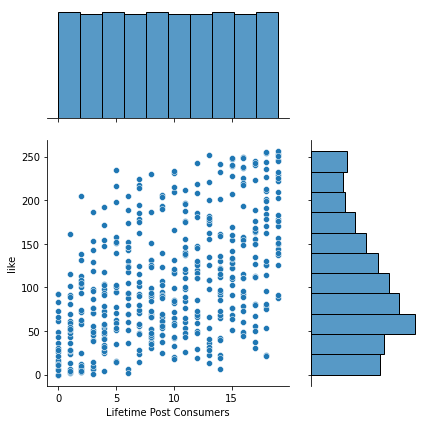

In [8]:
sns_plot = sns.jointplot(x="Lifetime Post Consumers", y="like", data=y_df, ratio=2)

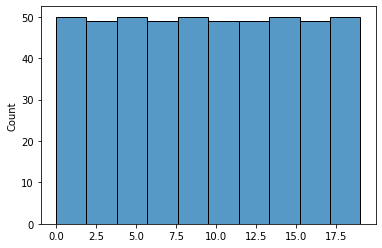

In [9]:
sns_plot = sns.histplot(y, kde=False)

In [12]:
dummy_clf = DummyClassifier(strategy='stratified')
dummy_clf.fit(x, y)
print("Dummy ACC: %.2f" % acc(y, dummy_clf.predict(x)))

Dummy ACC: 0.05


In [14]:
clf = ExtraTreesClassifier(n_estimators=1000, max_depth=4)
scores = cross_val_score(clf, x, y, cv=10, scoring=make_scorer(acc))  
print("ACC: %.2f +/- %.2f" % (scores.mean(), scores.std()))

ACC: 0.15 +/- 0.05


In [15]:
clf = ExtraTreesClassifier(n_estimators=20000, max_depth=4)
clf.fit(x, y)
print("ExtraTrees ACC = %.2f" % acc(y, clf.predict(x)))

ExtraTrees ACC = 0.41


[3 1 2 0 5 4 6]
Feature ranking:
1. Post Month (0.265077)
2. Page total likes (0.233591)
3. Type (0.209504)
4. Category (0.083580)
5. Post Weekday (0.073395)
6. Post Hour (0.071327)
7. Paid (0.063527)


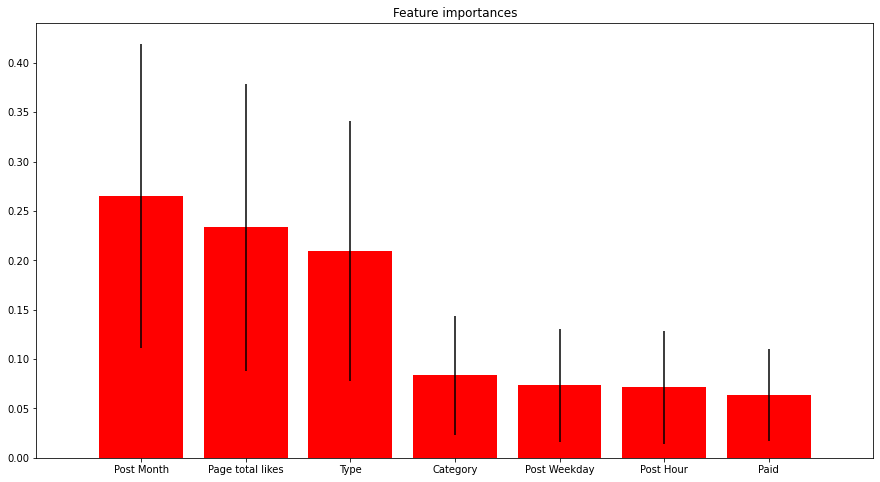

In [17]:
importances = clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]
print(indices)

print("Feature ranking:")

for f in range(x.shape[1]):
    print("%d. %s (%f)" % (f + 1, features[indices[f]],  importances[indices[f]]))

fig = plt.figure()
plt.title("Feature importances")
plt.bar(range(x.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(x.shape[1]), np.array(features)[indices])
plt.xlim([-1, x.shape[1]])
plt.ylim([0, None])

fig.set_size_inches(15, 8)

In [19]:
def plot_confusion_matrix(conf_mat, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
  
    if normalize:
        conf_mat = conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    plt.imshow(conf_mat, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    for i, j in itertools.product(range(conf_mat.shape[0]), range(conf_mat.shape[1])):
        t = "(%.2f)" % (conf_mat[i, j])
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Normalized confusion matrix


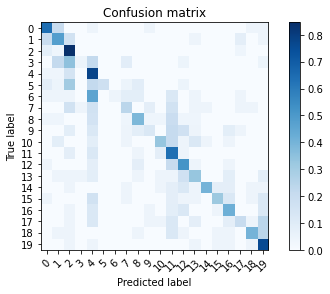

In [20]:
y_pred = clf.predict(x)
cnf_matrix = confusion_matrix(y, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=range(len(set(y))), normalize=True,
                      title='Confusion matrix')